# Create a Gen 3 Pipeline to run wavefront estimation tests

## Set up repo and run ISR from command-line with butler and pipetask

Here we show the command line script to ingest phosim images with the butler and then run a `pipetask` that performs ISR and then finds the donut location on the image.

In [1]:
! cat runIsr.sh

#!/bin/bash

butler create DATA
butler register-instrument DATA/ lsst.obs.lsst.LsstCamPhoSim
butler ingest-raws DATA /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/baselineTest/iter0/img/extra/
butler ingest-raws DATA /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/baselineTest/iter0/img/intra/
butler define-visits DATA/ lsst.obs.lsst.LsstCamPhoSim
butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstCamPhoSim
pipetask run -j 9 -b DATA/ -i LSSTCam-PhoSim/raw/all,LSSTCam-PhoSim/calib \
    -p testPhosimPipeline.yaml --register-dataset-types --output-run run1

The individual tasks within the `pipetask` are defined in the file `testPhosimPipeline.yaml`.

In [2]:
! cat testPhosimPipeline.yaml

description: phosim basic processing pipeline
instrument: lsst.obs.lsst.LsstCamPhoSim
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
  detectDonuts:
    class: lsst.ts.wep.detectDonutsTask.DetectDonutsTask
    config:
      connections.exposure: 'postISRCCD'
  zernikeEstimate:
    class: lsst.ts.wep.zernikeEstimateTask.ZernikeEstimateTask
    config:
      connections.exposures: 'postISRCCD'
      connections.inputCatalogs: 'donutCatalog'


What's inside the new tasks we created?


### `DetectDonutsTask`

First let's look at the one called `DetectDonutsTask`.

There are pieces of pipeline code but the important actions occur in the `run` method of the class `DetectDonutsTask`. There we get an exposure and convolve it with a template. Then we take the max value in the convolved image and save that as the location of the donut. This information is then output as a `sourceCatalog`.

In [3]:
! cat detectDonutsTask.py

import numpy as np

import lsst.pipe.base as pipeBase
import lsst.pex.config as pexConfig
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage

from lsst.ts.wep.Utility import DonutTemplateType, DefocalType
from lsst.ts.wep.cwfs.DonutTemplateFactory import DonutTemplateFactory
from scipy.signal import correlate

from lsst.pipe.base import connectionTypes


class DetectDonutsTaskConnections(pipeBase.PipelineTaskConnections,
                                  dimensions=("exposure", "detector")):
    exposure = connectionTypes.Input(doc="Input exposure to make measurements "
                                          "on",
                                     dimensions=("exposure", "detector"),
                                     storageClass="Exposure",
                                     name="postISRCCD")
    outputCatalog = connectionTypes.Output(doc="Donut Locations",
                                           dimensions=("exposure", "detector"),
                    

### `zernikeEstimateTask`

The `zernkeEstimateTask` picks up from here and loads the two exposures for each detector along with the source catalog for each exposure at the same time. It then extracts the donut image from each exposure as a stamp that it passes into the `ts_wep.WfEstimator` class to get an estimate of the Zernike coefficients. The Zernike coefficients are then saved as the output and accessible by the `Butler`.

In [4]:
! cat zernikeEstimateTask.py

import numpy as np

import lsst.pipe.base as pipeBase
import lsst.pex.config as pexConfig
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage

import os
import typing
from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.SourceProcessor import SourceProcessor
from lsst.ts.wep.Utility import getConfigDir, DefocalType

from lsst.pipe.base import connectionTypes


class ZernikeEstimateTaskConnections(pipeBase.PipelineTaskConnections,
                                     dimensions=("detector", "instrument")):
    exposures = connectionTypes.Input(doc="Input exposure to make measurements "
                                          "on",
                                      dimensions=("exposure", "detector", "instrument"),
                                      storageClass="Exposure",
                                      name="postISRCCD",
                                      multiple=True)
    inputCatalogs = connectionTypes.Input(doc="Input donut location ca

## Look inside repo

After running the script we have a data repository that we can explore with the `Butler`. It will have our postISR images as well as catalogs for each exposure that show the location of the donut.

In [5]:
from lsst.daf import butler as dafButler

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
butler = dafButler.Butler('DATA')

In [8]:
registry = butler.registry

In [9]:
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('donutCatalog', {band, instrument, detector, physical_filter, exposure}, SourceCatalog)
DatasetType('detectDonuts_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('detectDonuts_config', {}, Config)
DatasetType('packages', {}, Packages)
DatasetType('zernikeArray', {band, instrument, detector, physical_filter, exposure}, NumpyArray)
DatasetType('zernikeEstimate_metadata', {instrument, detector}, PropertySet)
DatasetType('zernikeEstimate_config', {}, Config)
DatasetType('zernikeEstimate', {band, instrument, detector, physical_filter, exposure}, NumpyArray)


In [10]:
for x in registry.queryCollections():
    print(x)

LSSTCam-PhoSim/raw/all
LSSTCam-PhoSim/calib
LSSTCam-PhoSim/calib/unbounded
run1


In [11]:
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())

{instrument: 'LSSTCam-PhoSim', detector: 91, exposure: 9006001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 93, exposure: 9006001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 96, exposure: 9006002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 94, exposure: 9006001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 93, exposure: 9006002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 91, exposure: 9006002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 98, exposure: 9006002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 90, exposure: 9006002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 95, exposure: 9006001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam-PhoSim', detector: 97, exposure: 9006002, ...}
{instrument, 

In [12]:
dataId={'instrument': 'LSSTCam-PhoSim', 'detector': 94, 'exposure': 9006001}

### Load a postISR image

In [13]:
postIsrExp = butler.get('postISRCCD', dataId=dataId, collections=['run1'])

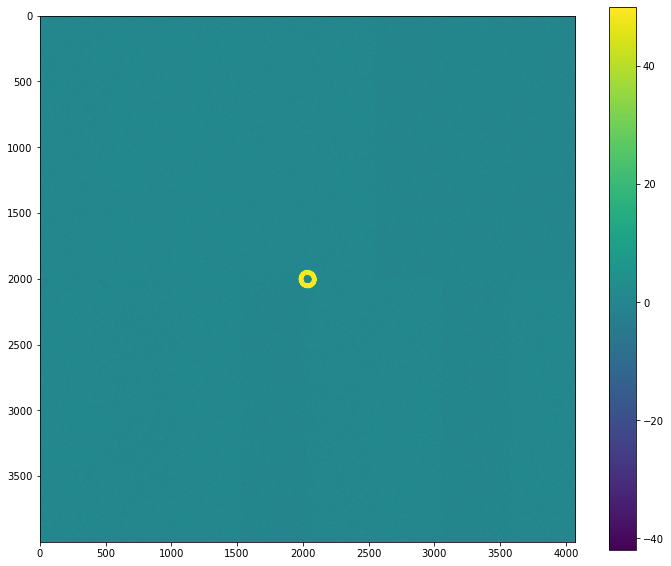

In [14]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp.image.array, vmax=50)
plt.colorbar()

### Load the donut catalog for an exposure

In [15]:
srcCat = butler.get('donutCatalog', dataId=dataId, collections=['run1'])

In [16]:
srcCat

<class 'lsst.afw.table.SourceCatalog'>
 id coord_ra coord_dec parent xPixel yPixel
      rad       rad                        
--- -------- --------- ------ ------ ------
  1      nan       nan      0 2032.0 2004.0

### Load the Zernike coefficients

In [17]:
dataId={'instrument': 'LSSTCam-PhoSim', 'detector': 94, 'exposure': 9006001}

In [18]:
zerCoeff = butler.get('zernikeEstimate', dataId=dataId, collections=['run1'])

In [19]:
zerCoeff

array([-0.63606748,  0.84018918,  0.54887045,  0.01308049,  0.35250097,
       -0.00763795,  0.10555912,  0.00923791, -0.01103009, -0.05209427,
        0.03410271,  0.02286369, -0.0526768 ,  0.00351468, -0.02517337,
        0.01012988, -0.03457012,  0.08363404, -0.01039912])

## Testing on `LsstCam` data

All of the above work was done using the `lsst.obs.lsst.LsstCamPhoSim` `instrument` since it was before the latest update to `phosim_utils`. Here we test using data created using the PhoSim but with the `lsst.obs.lsst.LsstCam` `instrument`.

In [20]:
butler_lsstCam = dafButler.Butler('DATA_lsstCam')

In [21]:
registry_lsstCam = butler_lsstCam.registry

In [22]:
datasetRefs = list(registry_lsstCam.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())

{instrument: 'LSSTCam', detector: 95, exposure: 4000021706001, ...}
{instrument, detector, exposure}


In [23]:
dataId_lsstCam = datasetRefs[0].dataId

### Look at PostISR Image

In [24]:
postIsrExp_lsstCam = butler_lsstCam.get('postISRCCD', dataId=dataId_lsstCam, collections=['run1'])

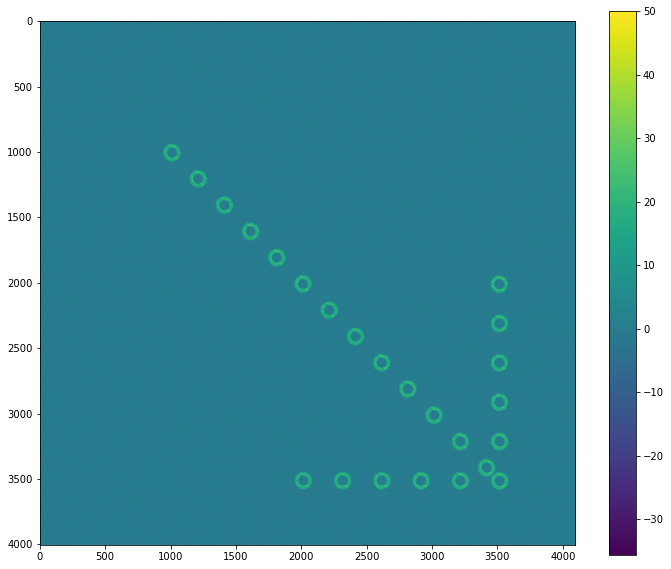

In [25]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp_lsstCam.image.array, vmax=50)
plt.colorbar()